<a href="https://colab.research.google.com/github/DilanDoshi/m148_heart_failure_predictors-/blob/main/M148_Heart_Failure_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M148 Heart Failure project
Cardiovascular diseases (CVDs) are the leading cause of death globally, responsible for an estimated 17.9 million deaths each year—approximately 31% of all deaths worldwide. Heart failure, a common consequence of CVDs, poses a major health burden that requires timely prediction and intervention. This project utilizes a dataset containing 12 clinical features to develop a machine learning model for predicting mortality due to heart failure. Early identification of high-risk patients through such predictive modeling can support proactive disease management and improve patient outcomes.

## Imports and Dataset

In [7]:
import numpy as np, pandas as pd, glob, os
import kagglehub

In [8]:
# Download latest version of dataset
path = kagglehub.dataset_download("andrewmvd/heart-failure-clinical-data")
print("Path to dataset: ", path)

Using Colab cache for faster access to the 'heart-failure-clinical-data' dataset.
Path to dataset:  /kaggle/input/heart-failure-clinical-data


In [28]:
# Store data into pd dataframe
df = pd.read_csv(os.path.join(path, "heart_failure_clinical_records_dataset.csv"))
print("Dataset shape: ", df.shape)
print(df.sum())
df.head(5)

Dataset shape:  (299, 13)
age                         1.818933e+04
anaemia                     1.290000e+02
creatinine_phosphokinase    1.739700e+05
diabetes                    1.250000e+02
ejection_fraction           1.138700e+04
high_blood_pressure         1.050000e+02
platelets                   7.874405e+07
serum_creatinine            4.167700e+02
serum_sodium                4.085100e+04
sex                         1.940000e+02
smoking                     9.600000e+01
time                        3.894800e+04
DEATH_EVENT                 9.600000e+01
dtype: float64


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Data Analysis and Cleaning

In [11]:
# Check if we have missing values ('nan')

df.isna().sum()

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


In [16]:
# Data Cleaning: Checking for outliers

non_binary_columns = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
quantile_1 = df[non_binary_columns].quantile(0.25)
quantile_3 = df[non_binary_columns].quantile(0.75)
iqr = quantile_3 - quantile_1
lower_bound = quantile_1 - 1.5 * iqr
upper_bound = quantile_3 + 1.5 * iqr

outliers = (df[non_binary_columns] < lower_bound) | (df[non_binary_columns] > upper_bound)

print("Outliers: ")
outliers.sum()

Outliers: 


,0
creatinine_phosphokinase,29
ejection_fraction,2
platelets,21
serum_creatinine,29
serum_sodium,4


In [18]:
# Data Cleaning: Remove outliers

rows_w_outliers = outliers.any(axis=1)
df_clean = df[~rows_w_outliers] # return dataframe without outliers

df_clean.shape


(224, 13)

In [ ]:
# Get rid of unncessary features

### EDA

In [39]:
import matplotlib.pyplot as plt

Total deaths with diabetes:  24
Total deaths without diabetes:  37


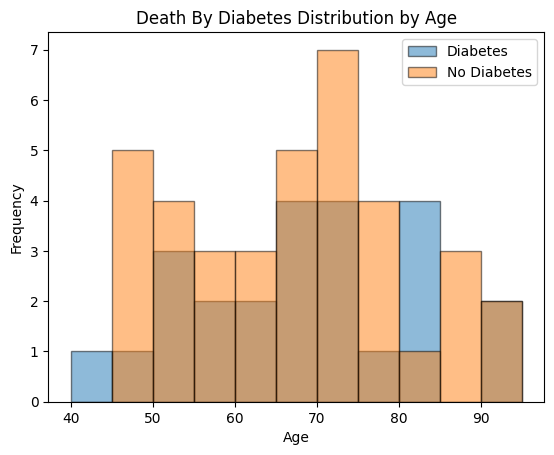

In [30]:
# Histogram: Diabetes against age

ages_with_diabetes = df_clean.loc[(df_clean['diabetes'] == 1) & (df_clean['DEATH_EVENT'] == 1), 'age']
ages_without_diabetes = df_clean.loc[(df_clean['diabetes'] == 0) & (df_clean['DEATH_EVENT'] == 1), 'age']
total_death_w_diabetes = len(ages_with_diabetes)
total_death_wo_diabetes = len(ages_without_diabetes)

print("Total deaths with diabetes: ", total_death_w_diabetes)
print("Total deaths without diabetes: ", total_death_wo_diabetes)


# Build 5-year bins covering the full age range
age_min = df_clean['age'].min()
age_max = df_clean['age'].max()

bins = np.arange(
    (age_min // 5) * 5,              # floor to nearest 5
    ((age_max + 4) // 5) * 5 + 5,    # ceil to nearest 5, then add one step
    5
)

plt.hist(ages_with_diabetes, bins=bins, alpha=0.5, label='Diabetes', edgecolor = 'black')
plt.hist(ages_without_diabetes, bins=bins, alpha=0.5, label='No Diabetes', edgecolor = 'black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Death By Diabetes Distribution by Age')
plt.legend()
plt.show()



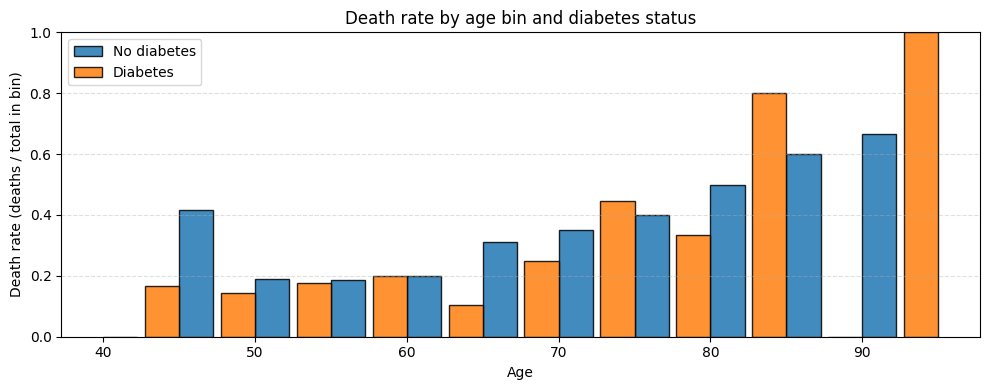

In [38]:
# Change to Death Rate

# Denominators:
total_age_w_diabetes = df_clean.loc[df_clean['diabetes'] == 1, 'age']
total_age_wo_diabetes = df_clean.loc[df_clean['diabetes'] == 0, 'age']

# Build common 5-year bins covering the data
age_min, age_max = df_clean['age'].min(), df_clean['age'].max()
bins = np.arange((age_min // 5) * 5, ((age_max + 4) // 5) * 5 + 5, 5)

death_d1, _ = np.histogram(ages_with_diabetes, bins=bins)
death_d0, _ = np.histogram(ages_without_diabetes, bins=bins)

total_d1, _ = np.histogram(total_age_w_diabetes, bins=bins)
total_d0, _ = np.histogram(total_age_wo_diabetes, bins=bins)

rate_d1 = np.divide(death_d1, total_d1, out=np.zeros_like(death_d1, dtype=float), where=total_d1 > 0)
rate_d0 = np.divide(death_d0, total_d0, out=np.zeros_like(death_d0, dtype=float), where=total_d0 > 0)

lefts  = bins[:-1]
widths = np.diff(bins)
w = widths * 0.45  # each bar ~45% of bin width

plt.figure(figsize=(10,4))
plt.bar(lefts, rate_d0, width=w, align='edge', label='No diabetes', edgecolor='black', alpha=0.85)
plt.bar(lefts + widths-w, rate_d1, width=w, align='edge', label='Diabetes',    edgecolor='black', alpha=0.85)
plt.xlabel('Age')
plt.ylabel('Death rate (deaths / total in bin)')
plt.ylim(0, 1)
plt.title('Death rate by age bin and diabetes status')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [32]:
# Plot histogram for frequency of death against serum_sodium levels